In [1]:
import json
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color']

from sklearn.metrics import average_precision_score, precision_recall_curve, auc, roc_curve

import sys
sys.path.append('..')
from lib import *
from numba import njit

plt.style.use('../peptidome.mplstyle')

In [2]:
proteome = 'Humanviruses'
all_data = {}
for i, model in enumerate(['independent', 'ncov', 'nskew', 'nskewfcov']):

    arr = np.load('data/{proteome}_{model}_k9_likelihoods.npz'.format(proteome=proteome, model=model))
    df = pd.read_csv('../maxent/data/{proteome}_{model}_k9_dkl.csv'.format(proteome=proteome, model=model),
                     index_col=0, squeeze=True)
    dkl = df.loc['DKL']
    data = {}

    logp_hh, logp_pp, logp_hp, logp_ph = arr['logp_hh'], arr['logp_pp'], arr['logp_hp'], arr['logp_ph']
    data['logp_hh'], data['logp_pp'], data['logp_hp'], data['logp_ph'] = logp_hh, logp_pp, logp_hp, logp_ph

    positive = logp_pp-logp_ph
    negative = logp_hp-logp_hh
    data['positive'] = np.sort(positive)*np.log10(np.exp(1))
    data['negative'] = np.sort(negative)*np.log10(np.exp(1))
    data['dkl'] = dkl
    
    all_data[model] = data

In [3]:
np.mean(all_data['nskewfcov']['positive'])/np.log10(np.exp(1)), all_data['nskewfcov']['dkl']

(0.15691053492722834, 0.17817676201696386)

Text(0, 0.5, '# peptides')

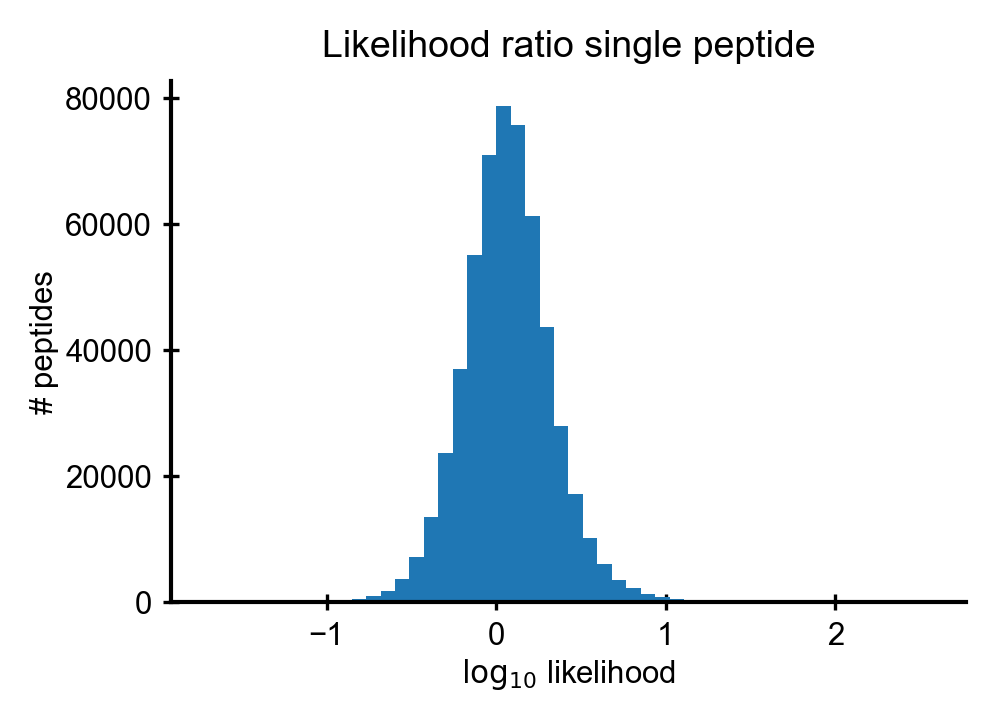

In [11]:
plt.title('Likelihood ratio single peptide')
plt.hist(positive, bins=50);
plt.xlabel('$\log_{10}$ likelihood')
plt.ylabel('# peptides')

In [6]:
positive = all_data['nskewfcov']['positive']
Npeptides = 100
Ndraws = 10000
draws = np.random.choice(positive, size=(Ndraws, Npeptides))
likelihood_ratio = np.sum(draws, axis=1)

Text(0.5, 0, '$log_{10}$ likelihood')

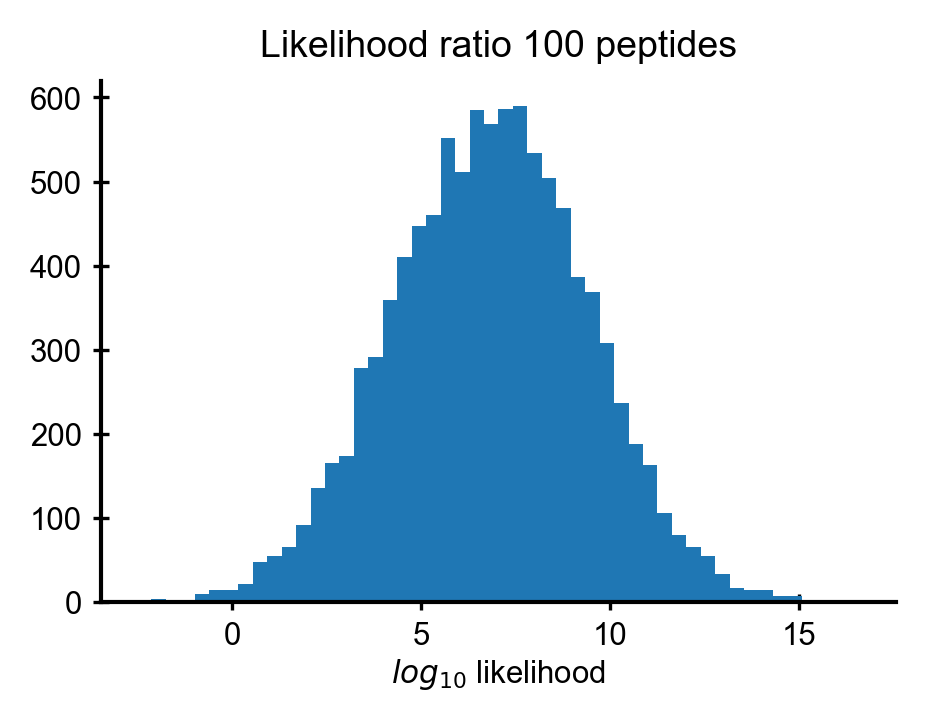

In [12]:
plt.title('Likelihood ratio 100 peptides')
plt.hist(likelihood_ratio, bins=50)
#plt.axvline(all_data['nskewfcov']['dkl']*Npeptides*np.log10(np.exp(1)), color='k')
plt.xlabel('$log_{10}$ likelihood')

In [14]:
def calculate_threshold(alpha, Ndraws=1e6, Npeptides=1, negative=all_data['nskewfcov']['negative']):
    """ Calculate likelihood ratio threshold at a given alpha level.
    """
    Ndraws = int(Ndraws)
    Npeptides = int(Npeptides)
    draws = np.random.choice(negative, size=(Ndraws, Npeptides))
    likelihood_ratio = np.sum(draws, axis=1)
    return np.sort(likelihood_ratio)[-int(alpha * len(likelihood_ratio))]

In [15]:
calculate_threshold(1e-3, Ndraws=1e5, Npeptides=100)

0.6367847393779587

In [20]:
thresholds = [1, 2, 3, 4, 5, 6]
positive = all_data['nskewfcov']['positive']
Ndraws = 10000

Npeptidess = np.logspace(0, 2.5, 30)#[1, 2, 5, 10, 20, 50, 100, 200, 500]
p_detections = np.zeros(shape=(len(thresholds), len(Npeptidess)))
for i, threshold in enumerate(thresholds):
    for j, Npeptides in enumerate(Npeptidess):
        Npeptides = int(Npeptides)
        draws = np.random.choice(positive, size=(Ndraws, Npeptides))
        likelihood_ratio = np.sum(draws, axis=1)
        likelihood_threshold = calculate_threshold(10**-threshold, Ndraws=1e5, Npeptides=Npeptides)
        print(threshold, Npeptides, likelihood_threshold)
        p_detection = np.sum(likelihood_ratio > likelihood_threshold)/Ndraws
        p_detections[i, j] = p_detection

1 1 0.2421752253897398
1 1 0.24114070587126887
1 1 0.24163719508635328
1 1 0.2415762874821365
1 2 0.31128066224664236
1 2 0.31146455676806406
1 3 0.3443833788778016
1 4 0.3643194225271419
1 4 0.36916580966341817
1 5 0.3711386018336067
1 7 0.35600914723263566
1 8 0.34964414958773454
1 10 0.30950399638420845
1 13 0.23353292630045042
1 16 0.13369513918571113
1 19 0.03649590832831147
1 23 -0.11135584998640449
1 29 -0.3863427655757181
1 35 -0.6599322554519877
1 43 -1.0566891083373933
1 52 -1.5444685547037715
1 64 -2.207630289483915
1 78 -2.9794859198347403
1 96 -4.064173819997493
1 117 -5.380128489151394
1 142 -6.904046223214652
1 174 -8.946660694906175
1 212 -11.439350230434156
1 259 -14.604196192660917
1 316 -18.48112883442409
2 1 0.5384555488290409
2 1 0.5285920887146842
2 1 0.5312144611850081
2 1 0.534486410467336
2 2 0.7067767310162318
2 2 0.7040142339796627
2 3 0.8166035053265717
2 4 0.9015749550467803
2 4 0.9144938103060494
2 5 0.9701962545712126
2 7 1.0620050921608195
2 8 1.11297807

Text(0.5, 0, 'Number of samples')

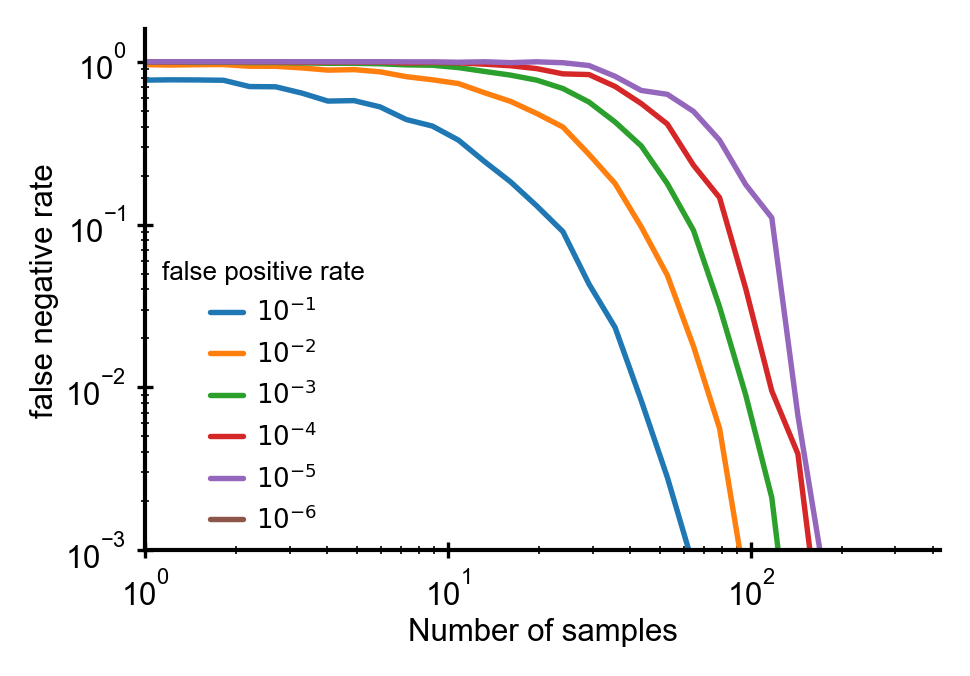

In [21]:
for i, threshold in enumerate(thresholds):
    plt.plot(Npeptidess, 1-p_detections[i, :], '-', label='$10^{-%g}$'%threshold)
plt.legend(title='false positive rate')
#plt.axvline(threshold/(all_data['nskewfcov']['dkl']*np.log10(np.exp(1))), color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1.0)
plt.ylim(bottom=1e-3)
plt.ylabel('false negative rate')
plt.xlabel('Number of samples')

In [23]:
alpha = 1e-3
positive = all_data['nskewfcov']['positive']
negative = all_data['nskewfcov']['negative']
Ndraws = int(1e5)
recalls =  np.logspace(0, -2, 25)

Npeptidess = np.logspace(0, 2.3, 50)#[1, 2, 5, 10, 20, 50, 100, 200, 500]
Npeptidess = np.unique([int(N) for N in Npeptidess])
p_detections = np.zeros(shape=(len(recalls), len(Npeptidess)))
for i, recall in enumerate(recalls):
    for j, Npeptides in enumerate(Npeptidess):
        Npeptides = int(Npeptides)
        top = positive[-int(recall*len(positive)):]
        draws = np.random.choice(top, size=(Ndraws, Npeptides))
        likelihood_ratio = np.sum(draws, axis=1)
        # need to calculate likelihood threshold by also restricting negative examples to the same subspace
        top_negative = negative[-int(recall*len(negative)):]
        likelihood_threshold = calculate_threshold(alpha, Ndraws=1e5,
                                                   Npeptides=Npeptides, negative=top_negative)
        #print(recall, Npeptides, likelihood_threshold)
        p_detection = np.sum(likelihood_ratio > likelihood_threshold)/Ndraws
        p_detections[i, j] = p_detection

Text(0, 0.5, 'Recall')

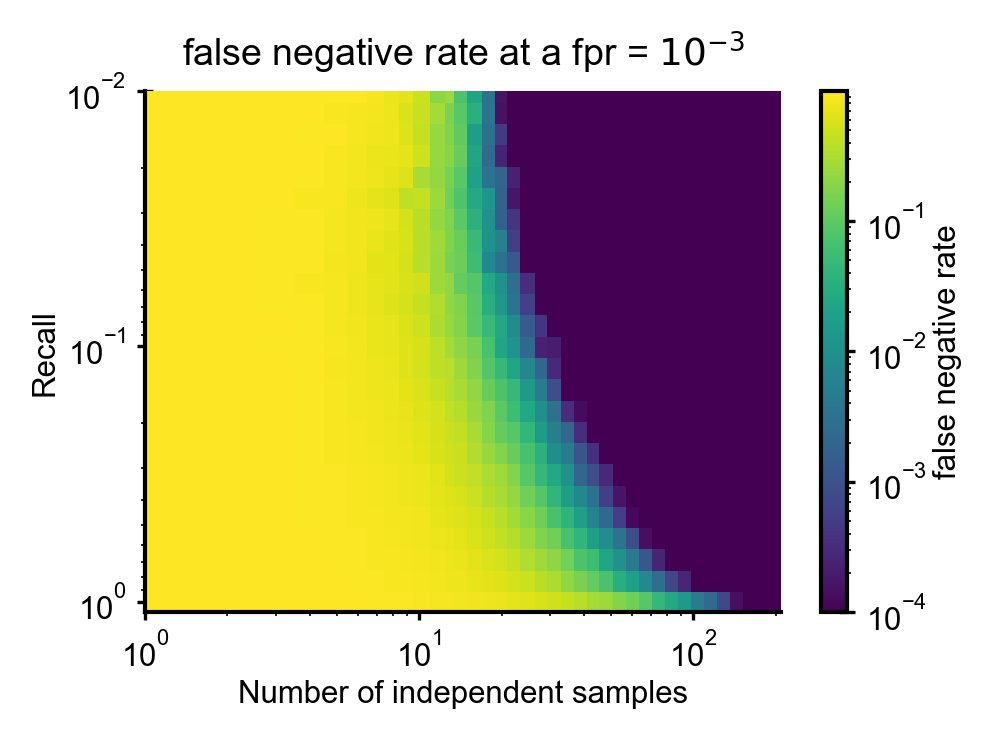

In [24]:
plt.title('false negative rate at a fpr = $10^{-3}$')
plt.pcolormesh(Npeptidess, recalls, 1-p_detections+1e-10,
               norm=matplotlib.colors.LogNorm(vmin=1e-4), shading='nearest')
plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='false negative rate')
plt.xlim(1.0)
plt.ylim(1.1e0, 1e-2)
plt.xlabel('Number of independent samples')
plt.ylabel('Recall')